### *PREDICTING AGE AT SCAN (PMA) USING RANDOM FOREST REGRESSION*

-----------------------------

*Dimitrova et al. (2021) '**Preterm birth alters the development of cortical microstructure and morphology at term-equivalent age**' biorxiv* 

-----------------------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb
import re
import os
from datetime import datetime
from scipy.stats import spearmanr

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import skopt

***LOAD DATA:***

In [3]:
wd = os.getcwd()
dd = wd + '/data'
pars_dir = wd + '/random_parcels'
out_dir = wd + '/output'

# train data:
X_train = pd.read_csv('{}/train_term_data.csv'.format(dd)).values
y_train = pd.read_csv('{}/train_term_cov.csv'.format(dd), header = None).values[:,0] # remove sex

# hold-out test data:
X_test = pd.read_csv('{}/test_term_data.csv'.format(dd)).values
y_test = pd.read_csv('{}/test_term_cov.csv'.format(dd), header = None).values[:,0] # remove sex

# get regions and surface parcel No.
columns = pd.read_csv('{}/train_term_data.csv'.format(dd)).columns

parcel_no = np.zeros((int(len(columns)/8)))
parcel = columns[:parcel_no.shape[0]]
for i in range(0, parcel_no.shape[0]):
    parcel_no[i] = int(''.join(re.findall('_([0-9]+)', parcel[i])))
    
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(196, 2288) (196,)
(63, 2288) (63,)


-----------------
***BASE RANDOM FOREST MODEL:***

BASE MODEL: train MAE: 0.26


Text(0.5, 1.0, 'Base model')

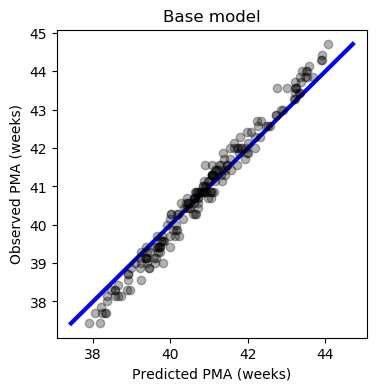

In [80]:
rf_base = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs = -2)
rf_base.fit(X_train, y_train)

pred_train = rf_base.predict(X_train)
print('BASE MODEL: train MAE: {:.2f}'.format(mean_absolute_error(y_train, pred_train)))

fig, ax = plt.subplots(1, figsize = (4,4))
ax.scatter(pred_train, y_train, color = 'black', alpha = 0.3, zorder = 2)
ax.set_xlabel('Predicted PMA (weeks)')
ax.set_ylabel('Observed PMA (weeks)')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-', lw = 3, zorder = 1)
ax.set_title('Base model')

-----------------------------------------
***ERROR-IN-VARIABLES BIAS CORRECTION:***


BASE MODEL EIV-corr: train MAE: 0.18


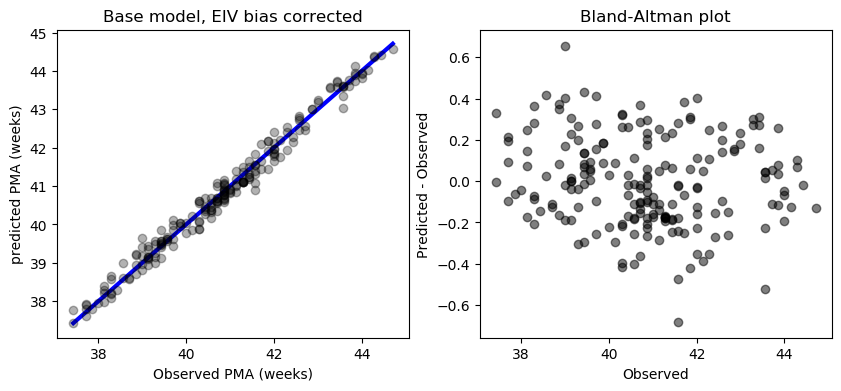

In [81]:
reg = LinearRegression().fit(pred_train[:, None], y_train)
pred_train_corr = pred_train * reg.coef_ + reg.intercept_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4))

ax1.scatter(y_train,pred_train_corr, color = 'black', alpha = 0.3, zorder = 2)
ax1.set_xlabel('Observed PMA (weeks)')
ax1.set_ylabel('predicted PMA (weeks)')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'blue', zorder = 1, lw = 3)
ax1.set_title('Base model, EIV bias corrected')

ax2.scatter(y_train,pred_train_corr-y_train,  color = 'black', alpha = 0.5)
ax2.set_xlabel('Observed')
ax2.set_ylabel('Predicted - Observed')
ax2.set_title('Bland-Altman plot')

print('BASE MODEL EIV-corr: train MAE: {:.2f}'.format(mean_absolute_error(y_train, pred_train_corr)))

------------------------
***HYPER-PARAMETER SEARCH:***

*n_estimators, max_depth, min_sample_leaf, max_features*

*pick hyperparameter opmisised (HO) model* 

In [7]:
from sklearn.pipeline import Pipeline
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 

rf_search_params = {"model__n_estimators": Integer(20, 1000, prior = 'log-uniform'),
                    "model__max_depth": Integer(1, 50),
                    "model__min_samples_leaf":  Integer(2,50),
                    "model__max_features": Categorical(['sqrt', 'auto'])
                    }

pipe = Pipeline([('model', RandomForestRegressor(n_jobs = 2))])
random_state = np.random.RandomState(42)
search = BayesSearchCV(estimator = pipe,
                       search_spaces = rf_search_params,
                       n_jobs = 10,
                       cv = 5,
                       n_iter = 50,
                       scoring = 'neg_mean_absolute_error',
                       verbose = 4,
                       random_state = random_state,
                       return_train_score = True)

def on_step(optim_result):
    score = search.best_score_
    print("best score: %s params: %s" % (score, search.best_params_))

print("Start @", datetime.now().strftime("%H:%M:%S"))    

search.fit(X_train, y_train, callback = on_step)
skopt.dump(search, 'rf_params_search_results.pkl')

print("val. score: %s" % search.best_score_)
print("best params: %s" % str(search.best_params_))
print('train MAE: {:.2f}'.format(-search.score(X_train, y_train)))

print("End @", datetime.now().strftime("%H:%M:%S"))   

Start @ 15:09:43
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    7.3s remaining:   10.9s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    7.5s finished


best score: -1.4192472003678733 params: OrderedDict([('model__max_depth', 21), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 47), ('model__n_estimators', 329)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.5s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   10.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: -1.260451616552397 params: OrderedDict([('model__max_depth', 42), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 17), ('model__n_estimators', 952)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   37.4s remaining:   56.1s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   40.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   36.4s remaining:   54.6s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   38.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    3.8s finished


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    1.9s finished


best score: -1.2013623811902259 params: OrderedDict([('model__max_depth', 23), ('model__max_features', 'sqrt'), ('model__min_samples_leaf', 7), ('model__n_estimators', 445)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   52.3s remaining:  1.3min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   53.8s finished


best score: -1.1793931203050296 params: OrderedDict([('model__max_depth', 29), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 240)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.3min finished


best score: -1.1793931203050296 params: OrderedDict([('model__max_depth', 29), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 240)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   46.9s remaining:  1.2min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   47.2s finished


best score: -1.1793931203050296 params: OrderedDict([('model__max_depth', 29), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 240)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.8s finished


best score: -1.1793931203050296 params: OrderedDict([('model__max_depth', 29), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 240)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.3s finished


best score: -1.1793931203050296 params: OrderedDict([('model__max_depth', 29), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 240)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.8min finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.8s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   10.0s finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.9min finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    0.7s finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    0.7s finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.7s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   10.7s finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.3min finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    1.2s finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.5min finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.9min finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.4min finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])


/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.8min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.3min finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.6s finished


best score: -1.1751583658209421 params: OrderedDict([('model__max_depth', 50), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 550)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.8min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.3min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.4min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.7min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.2min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])


/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.8min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.7min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.7min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.7min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.7min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.4min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.5min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    7.3s remaining:   10.9s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    9.4s finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.6min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.0min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.5min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.4min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.3min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   18.2s remaining:   27.2s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   18.5s finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.8min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.8min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  3.2min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.3s finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  2.4min finished


best score: -1.1741116724344183 params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
val. score: -1.1741116724344183
best params: OrderedDict([('model__max_depth', 35), ('model__max_features', 'auto'), ('model__min_samples_leaf', 2), ('model__n_estimators', 1000)])
train MAE: 0.27
End @ 16:22:46


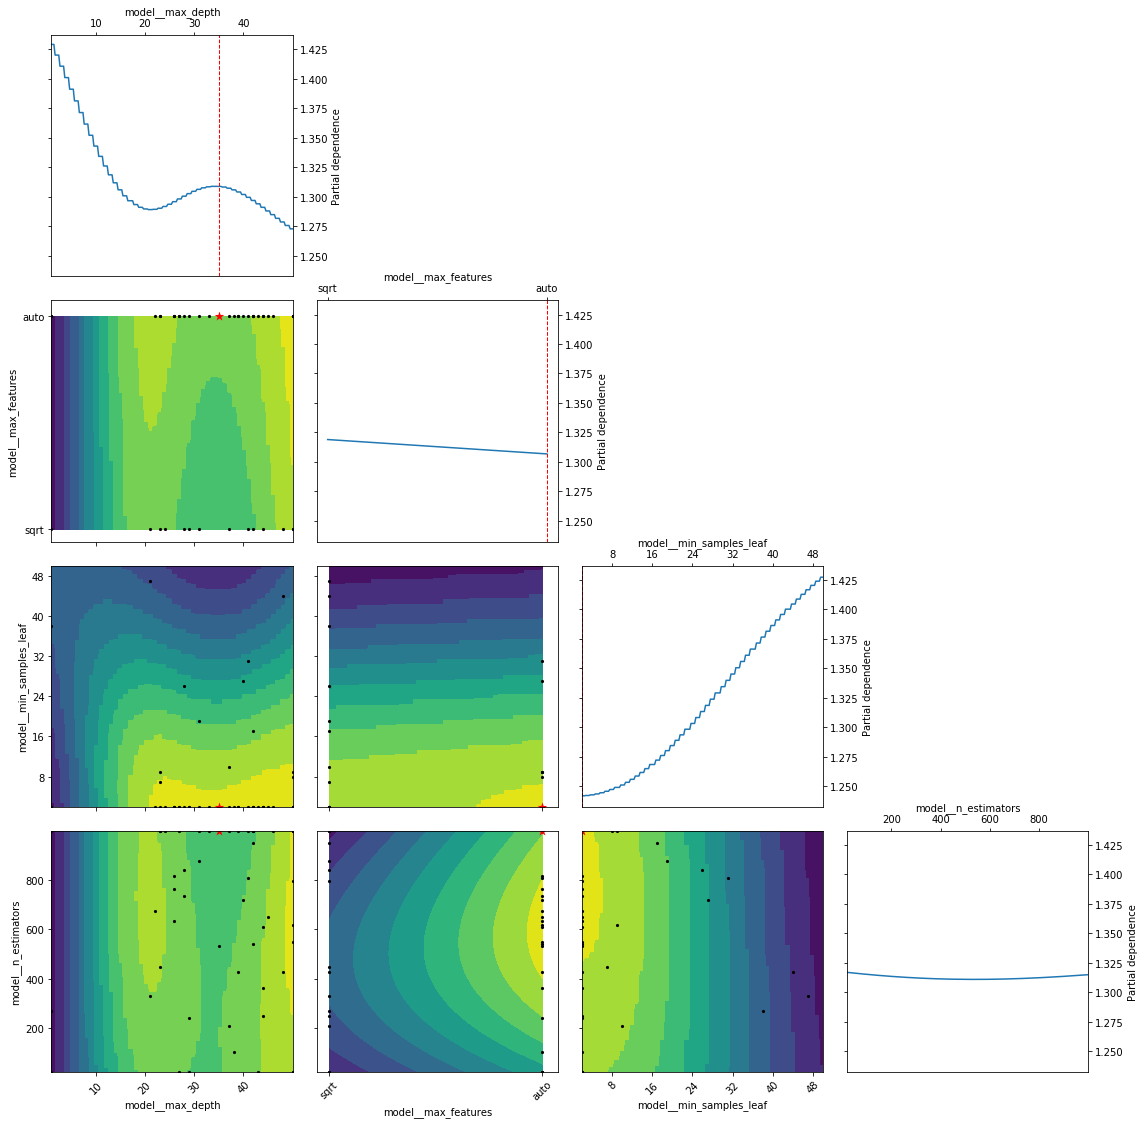

In [8]:
from skopt.plots import plot_objective
_ = plot_objective(search.optimizer_results_[0], n_points=200, size=4)

---------------------------------------
***PLOT HO VS BASE CORRECTED:***

train MAE: 0.18


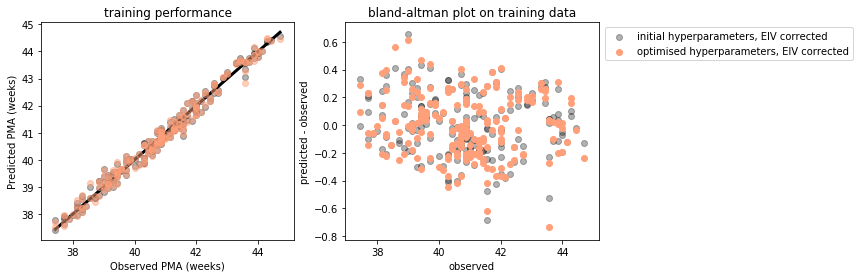

In [9]:
pred_trainOpt = search.best_estimator_.predict(X_train)
regOpt = LinearRegression().fit(pred_trainOpt[:, None], y_train)
pred_trainOpt_corr = pred_trainOpt * regOpt.coef_ + regOpt.intercept_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4))

ax1.scatter(y_train, pred_train_corr, color = 'black', alpha = 0.3,
            label='initial hyperparameters, EIV corrected', zorder = 2)
ax1.scatter(y_train, pred_trainOpt_corr, color = 'lightsalmon', alpha = 0.5, 
            label='optimised hyperparameters, EIV corrected', zorder = 3)
ax1.set_xlabel('Observed PMA (weeks)')
ax1.set_ylabel('Predicted PMA (weeks)')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'black', lw = 3, zorder = 1)
ax1.set_title('training performance')

ax2.scatter(y_train, pred_train_corr-y_train, color = 'black', alpha = 0.3,
            label='initial hyperparameters, EIV corrected')
ax2.scatter(y_train, pred_trainOpt_corr-y_train, color = 'lightsalmon', 
         label='optimised hyperparameters, EIV corrected')
ax2.set_ylabel('predicted - observed')
ax2.set_xlabel('observed')
plt.title('bland-altman plot on training data')
ax2.legend(bbox_to_anchor=(2.02, 1))

print('train MAE: {:.2f}'.format(mean_absolute_error(y_train, pred_train_corr)))

----------------------------------
***APPLY HO MODEL TO TEST DATA:***

In [62]:
# EIV BIAS CORRECTION _TEST:
pred_testOpt = search.best_estimator_.predict(X_test)
pred_testOpt_corr = pred_testOpt * regOpt.coef_ + regOpt.intercept_

print('test_Opt_corr MAE:      {:.2f}'.format(mean_absolute_error(y_test, pred_testOpt_corr)))
print('test_Opt_corr MSE:      {:.2f}'.format(mean_squared_error(y_test, pred_testOpt_corr)))
print('test_Opt_corr Spearman: {:.2f}'.format(spearmanr(y_test, pred_testOpt_corr)[0]))
print('test_Opt_corr R2 score: {:.2f}'.format(r2_score(y_test, pred_testOpt_corr)))

test_Opt_corr MAE:      0.60
test_Opt_corr MSE:      0.56
test_Opt_corr Spearman: 0.85
test_Opt_corr R2 score: 0.74


-------------------------
`SUPPLEMENTARY FIGURE 4.`

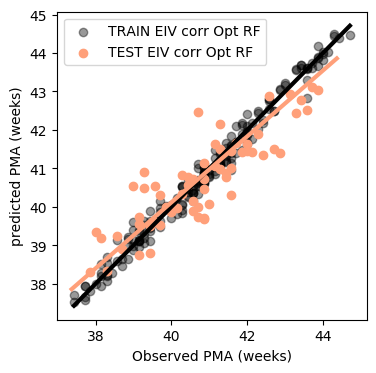

In [79]:
fig, ax = plt.subplots(1, figsize = (4,4))

plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k-', lw = 3)
plt.scatter(y_train, pred_trainOpt_corr, alpha=0.4, color = 'black', label = 'TRAIN EIV corr Opt RF')

x_ = np.linspace(min(y_test), max(y_test), 9)
y_ = regOpt.coef_*np.linspace(min(y_test), max(y_test), 9) + regOpt.intercept_

plt.plot(y_, x_, color = 'lightsalmon', lw = 3)
plt.scatter(y_test, pred_testOpt_corr, color = 'lightsalmon', label = 'TEST EIV corr Opt RF')

plt.xlabel('Observed PMA (weeks)')
plt.ylabel('predicted PMA (weeks)')
plt.legend()

plt.savefig('{}/obs_pred.png'.format(rf_plots), bbox_inches = 'tight', dpi = 200)

----------------
`SUPPLEMENTARY FIGURE 5.`

In [12]:
hemi_left = nb.load('{}/left_cortical_parcels.shape.gii'.format(pars_dir))
hemi_right = nb.load('{}/right_cortical_parcels.shape.gii'.format(pars_dir))

parcels_left = hemi_left.darrays[0].data
parcels_right = hemi_right.darrays[0].data

In [13]:
rf_opt = search.best_estimator_['model'].fit(X_train, y_train)

# create a dict with cortical feature +_+ parcel No.
features = dict(zip(columns,rf_opt.feature_importances_))

# get top 10%:
top_10 = int(np.round(len(features) * 0.1, 0))

sort_features_metric = []
sort_features_import = []

sort_features = sorted(features.items(), key=lambda x: x[1], reverse=True)
for i in sort_features:
    sort_features_metric.append(i[0]) # prints parcel + feature
    sort_features_import.append(i[1]) # prints value
    
features_top10_metric = sort_features_metric[0:top_10] 
features_top10_import = sort_features_import[0:top_10] 
features_top10_dict = dict(zip(features_top10_metric, features_top10_import))

data saved in `$wd/rf/surf` & `$wd/rf/plots`

In [57]:
rf_dir, rf_surf, rf_plots = (out_dir + '/rf') , (out_dir + '/rf/surf') , (out_dir + '/rf/plots')

for dir in (rf_dir, rf_surf, rf_plots):
    if not os.path.exists(dir):
        os.mkdir(dir)
    
for_pie = []
for_pie_no = []

for metric in ('fa','md','odi','ficvf','thick','curv','sulc', 'SA'):   
    f2parcel = {}
    
    for i in range(0,len(features_top10_import)):
        
        if re.search('^{}'.format(metric), features_top10_metric[i]): 
            parcel = ''.join(re.findall('_(\S+)',features_top10_metric[i]))
            f2parcel[float(parcel)] = features_top10_import[i]        
        
    print('metric: {} - total features: {}'.format(metric, len(f2parcel)))
    for_pie.append(len(f2parcel)/len(features_top10_metric))
    for_pie_no.append(len(f2parcel))
    for hemi in ('left','right'):
        if hemi == 'left':
                parcel_surf = parcels_left
                surface = hemi_left                
        else:
                parcel_surf = parcels_right
                surface = hemi_right
        
        f2surface = []
        
        for vertex in parcel_surf:
            if vertex in f2parcel.keys():
                f2surface.append(f2parcel.get(vertex))
            else:
                f2surface.append(0)
                            
        f2surface = np.array(f2surface, dtype = 'float32')
    
        surface.remove_gifti_data_array(0)
        surface.add_gifti_data_array(nb.gifti.GiftiDataArray(f2surface))
        nb.save(surface, '{}/{}_{}_feature_importance.func.gii'.format(rf_surf, metric, hemi))

metric: fa - total features: 14
metric: md - total features: 11
metric: odi - total features: 37
metric: ficvf - total features: 21
metric: thick - total features: 29
metric: curv - total features: 3
metric: sulc - total features: 6
metric: SA - total features: 108


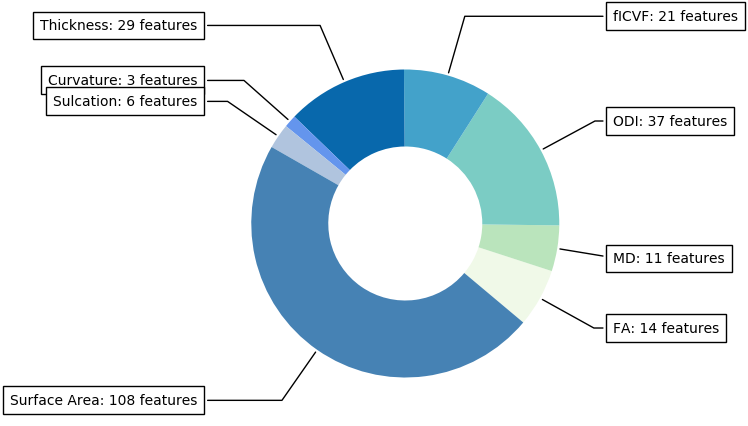

In [59]:
measures_pie = []

for metric, i in zip(('FA','MD','ODI','fICVF','Thickness','Curvature','Sulcation','Surface Area'), range(0,len(for_pie))):
    #print(metric, i)
    measures_pie.append('{}: {} features'.format(metric, for_pie_no[i]))

fig, ax = plt.subplots(figsize = (6, 5), subplot_kw = dict(aspect="equal"))
plt.style.use('default')

colours = ['#f0f9e8',
           '#bae4bc',
           '#7bccc4',
           '#43a2ca',
           '#0868ac',
           'cornflowerblue',
           'lightsteelblue' ,
           'steelblue']

recipe = measures_pie
data = for_pie
wedges, texts = ax.pie(data, wedgeprops = dict(width = 0.5), startangle = -40, colors = colours)

bbox_props = dict(boxstyle = "square,pad=0.5", fc = "w", ec = "k", lw = 1)
kw = dict(arrowprops = dict(arrowstyle = "-"), bbox = bbox_props, zorder = 0, va = "center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy = (x, y), xytext = (1.35*np.sign(x), 1.4*y),
                horizontalalignment = horizontalalignment, **kw)

plt.savefig('{}/feature_top10.png'.format(rf_plots), bbox_inches = 'tight', dpi = 200)